20.38 seconds


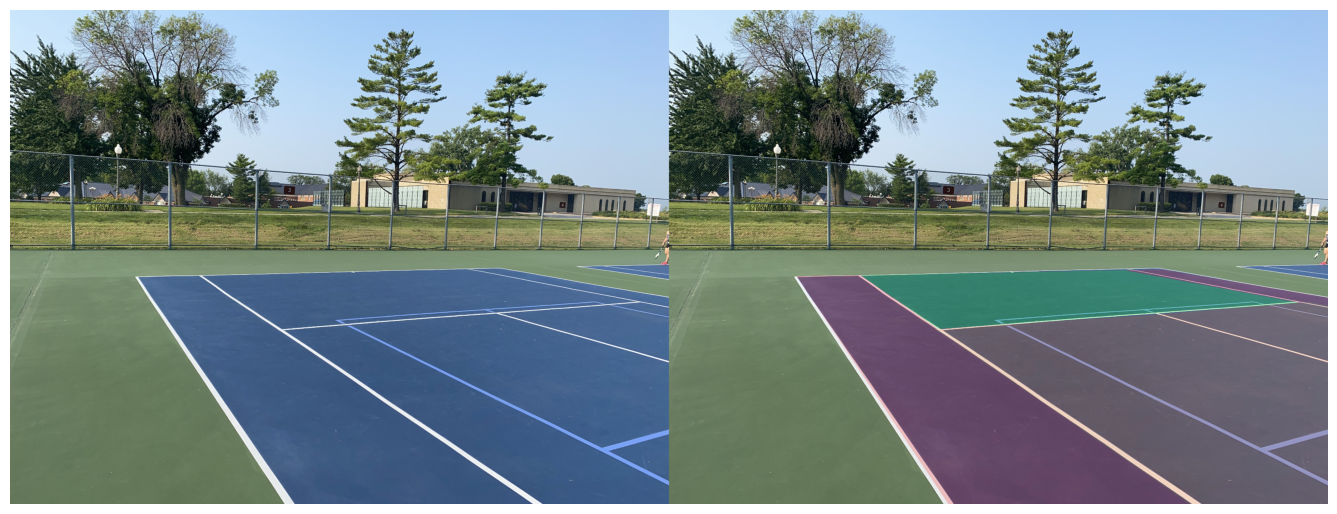

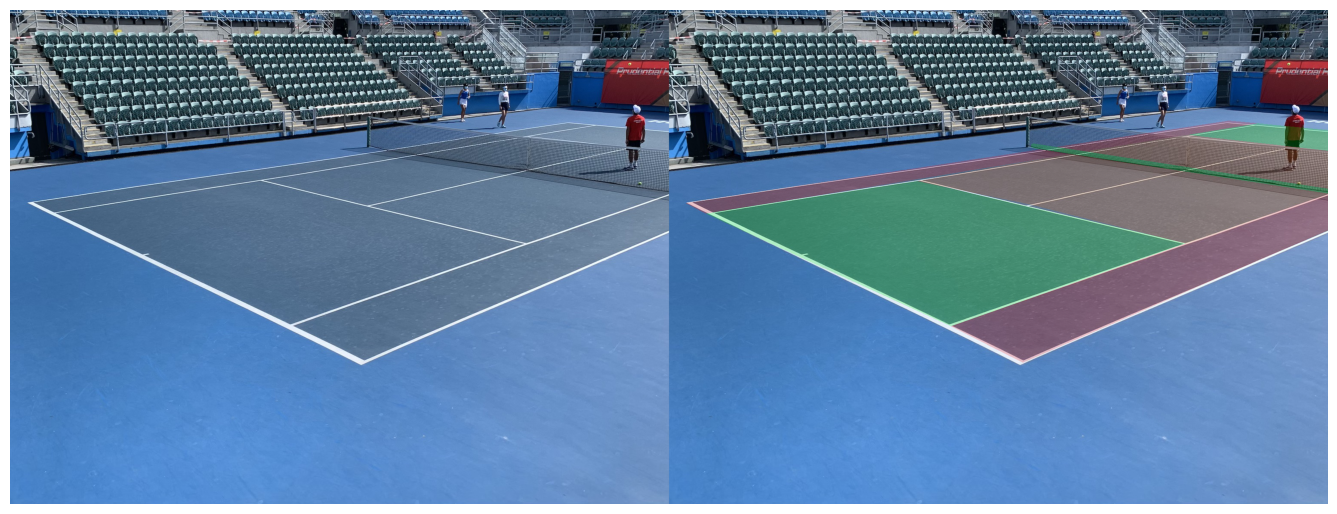

<Figure size 1700x700 with 0 Axes>

In [79]:
import os
import cv2
import time
import numpy as np
import multiprocessing
from matplotlib import pyplot as plt
from valid_homography_detection import find_valid_homographies
        
if __name__ == '__main__':
    image_folder = 'tennis_court_images'
    
    alpha = .8
    new_image_height = 1149
    canny_threshold0_end = 889
    canny_threshold0_start = 864
    
    start_time = time.time()
    plt.rcParams['figure.figsize'] = 17, 7
    
    for image in os.listdir(image_folder):
        valid_homographies = []
        queue = multiprocessing.Queue()
        rgb_image = cv2.cvtColor(cv2.imread(image_folder+'/'+image), cv2.COLOR_BGR2RGB)
        image_height, image_width, _ = rgb_image.shape
        rescale_factor = image_height/new_image_height
        rgb_image = cv2.resize(rgb_image, (int(image_width/rescale_factor), int(image_height/rescale_factor)))
        detection_image = rgb_image.copy()
        ps = [multiprocessing.Process(target=find_valid_homographies, args=[rgb_image, canny_threshold0, queue]) for canny_threshold0 in range(canny_threshold0_start, canny_threshold0_end)]
        [p.start() for p in ps]
        [p.join() for p in ps]
        
        while (not queue.empty()):
            valid_homographies.append(queue.get())
            
        if (valid_homographies):
            detected_and_predicted = min(valid_homographies, key=lambda valid_homography:valid_homography['homography_error'])['detected_and_predicted']

            for back_rectangle in [[1, 2, 6, 4], [14, 16, 19, 18]]:
                back_rectangle_coordinates = np.array([detected_and_predicted[back_rectangle_index] for back_rectangle_index in back_rectangle])

                if all(coordinate > 0 for coordinate in back_rectangle_coordinates.flatten()):
                    cv2.fillPoly(detection_image, [back_rectangle_coordinates], (0, 255, 0))

            for lane in [[0, 1, 9, 8], [8, 9, 18, 17], [2, 3, 12, 11], [11, 12, 20, 19]]:
                lane_coordinates = np.array([detected_and_predicted[lane_index] for lane_index in lane])

                if all(coordinate > 0 for coordinate in lane_coordinates.flatten()):
                    cv2.fillPoly(detection_image, [lane_coordinates], (255, 0, 0))

            for front_squares in [[4, 5, 10, 9], [9, 10, 15, 14], [5, 6, 11, 10], [10, 11, 16, 15]]:
                front_square_coordinates = np.array([detected_and_predicted[front_square_index] for front_square_index in front_squares])

                if all(coordinate > 0 for coordinate in front_square_coordinates.flatten()):
                    cv2.fillPoly(detection_image, [front_square_coordinates], (255, 100, 0))

            cv2.line(detection_image, (detected_and_predicted[7][0], detected_and_predicted[7][1]), (detected_and_predicted[13][0], detected_and_predicted[13][1]), (0, 255, 0), 10)
            plt.axis('off')
            plt.imshow(np.concatenate((rgb_image, cv2.addWeighted(rgb_image, alpha, detection_image, 1-alpha, 0)), axis=1))
            plt.figure()
        
    print(str(round(time.time() - start_time, 2)) + " seconds")
